# Diffusion model lab 
# Part 1/2: Pretraining of the VAE part of the architecture
---
- The goal of this notebook is to study the VAE involved in the latent diffusion model studied in the course. This network is pre-trained and used as a fix part in the diffusion model. 

<img src="img/presentation-ldm.png" alt="main diagram of a LDM model" width="600">


- <span style="color:red">Where is the VAE located in the diagram above?.</span>
- <span style="color:red">What is the purpose of using a VAE within a diffusion model?</span>


The VAE architecture is the same as the one you already studied in the previous lab, implemented using the `AutoencoderKL` class from MONAI. The main differences are:

1) the use of an adversarial strategy to encourage the VAE to reconstruct higher-quality images;
2) a more complex loss function, which includes a perceptual term and an adversarial term.

The adversarial term is directly related to the adversarial approach, while the perceptual term is designed to improve the quality of the reconstructed images. Both aspects will be further explored in this lab. The final loss can be expressed as:

<img src="img/final-loss.png" alt="Final loss" width="500">

```
Run the following cell to import the necessary libraries to work with the data and PyTorch.
```

In [1]:
# import libraries
import os
import contextlib

import torch
import torch.nn as nn
import monai
from monai.apps import MedNISTDataset
from monai.data import Dataset, DataLoader
from monai.data import Dataset as MonaiDataset
from monai.transforms import Compose, LoadImage, ToTensor
from monai.transforms import LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, Resized
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.networks.layers import Act

import numpy as np
from torch.utils.data import random_split
import torchvision
from torchinfo import summary
from tqdm.auto import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.manifold import TSNE
from IPython.display import Image, display
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Monai version: {monai.__version__}")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


PyTorch version: 2.5.1
Torchvision version: 0.20.1
Numpy version: 1.26.4
Monai version: 1.4.0+12.gc1ceea3d


---
## Load and Visualize the Data

Downloading may take a few moments, and you should see your progress as the data is loading.

```
Run the following cell to download and create Dataset from pytorch
```

In [2]:
# Path to store MedNIST dataset
data_dir = "data/MedNIST"

# Checks if data has already been downloaded
download = not os.path.exists(data_dir)

# Load dataset without reloading if data already exists
train_set = MedNISTDataset(root_dir='data', section="training", download=download, seed=0)
test_set = MedNISTDataset(root_dir='data', section="validation", download=download, seed=0)

Loading dataset: 100%|██████████| 5895/5895 [00:01<00:00, 3481.42it/s]


### Work with only the HAND class images

MedNIST is composed of 8 different types of image: Abdomen from CT, Breast from MRI, Chest from CT, Pulmonary fron X-ray, Hand from X-ray and Head from CT imaging. You may also choose to change the `batch_size` if you want to load more data at a time.

```
Run the following cell to select the type of images you're going to work with.
```

In [3]:
# how many samples per batch to load
batch_size = 64
image_size = 48 # the native image are of size 64x64. We set image_size ot 32 to reduce the complexity of the problem and make the training process faster
train_valid_ratio = 0.8
minv = 0 # min intensity value of each image after rescaling
maxv = 1 # max intensity value of each image after rescaling

labels = ['AbdomenCT','BreastMRI','ChestCT','CXR','Hand','HeadCT']
selected_label = labels[4] # ChestCt to avoid

# keep only the Hand images
train_datalist = [{"image": item["image"], "label": selected_label} for item in train_set.data if item["class_name"] == selected_label]
test_datalist = [{"image": item["image"], "label": selected_label} for item in test_set.data if item["class_name"] == selected_label]

# this part of the code remove some image cases where the hand is surrounded by a clear rectangle. 
# This trick reduces image variability and database size. This in turn reduces computation times in the lab.
def filter_images_by_intensity(datalist, threshold):
    filtered_datalist = []
    for item in datalist:
        image = LoadImage(image_only=True)(item["image"])  # Load original image
        nb_pixels = np.sum(image > 50)
        if nb_pixels <= threshold:  # Keep the image if the number of pixels is lower than the threshold value 
            filtered_datalist.append(item)
    return filtered_datalist

# filter the data lisst
train_datalist = filter_images_by_intensity(train_datalist, 1200)
test_datalist = filter_images_by_intensity(test_datalist, 1200)

# define the different transforms applied to the image before the generation of the dataset
all_transforms = [
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=minv, b_max=maxv, clip=True),
    Resized(keys=["image"], spatial_size=[image_size, image_size]),
]

# create the train / test datasets
train_dataset = Dataset(data=train_datalist, transform=Compose(all_transforms))
test_data = Dataset(data=test_datalist, transform=Compose(all_transforms))

# split the train_data into a train (80%) and valid (20%) subdataset
train_size = int(train_valid_ratio * len(train_dataset))    # 80% for training
valid_size = len(train_dataset) - train_size                # 20% for validation
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

# display the size of the different datasets 
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

Training dataset size: 1491
Validation dataset size: 373
Test dataset size: 223


### Visualize a Batch of Training Data

It's always important to check the accuracy of the data before going any further.

```
Run the cell below to display a subset of the training dataset and the size of a batch
```

The image batch size is (64, 1, 48, 48)


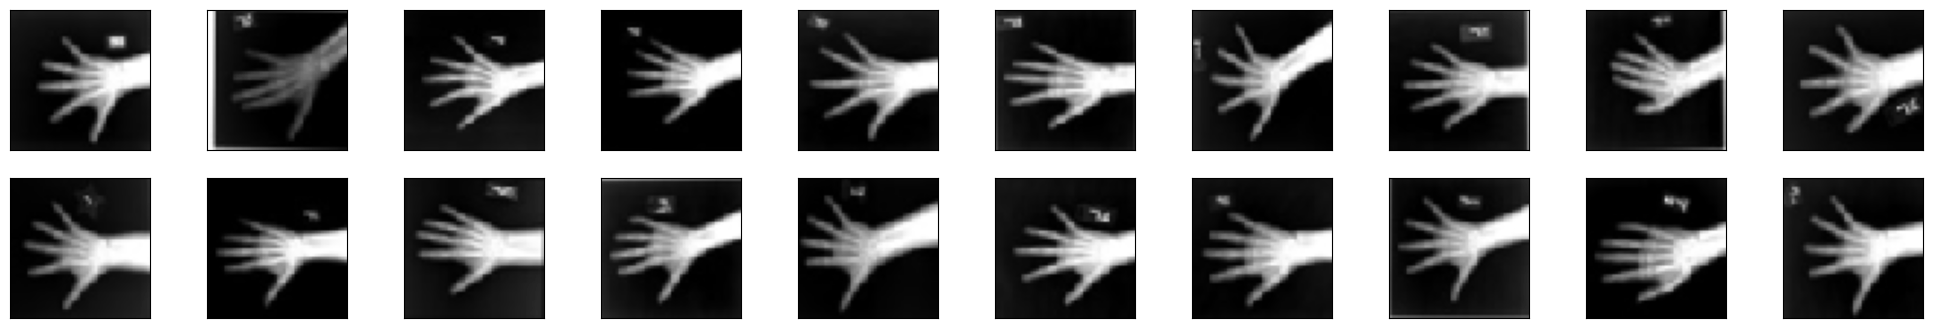

In [4]:
# obtain one batch of training images
dataiter_train = iter(train_loader)
batch = next(dataiter_train)
images = batch["image"]
images = images.numpy()
print(f"The image batch size is {images.shape}")

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')

### View an Image in More Detail

```
Run the cell below to display an image with the value of each pixel. This will enable you to check the operations performed by the transforms.Compose() function.
```

The size of an image from the dataset is (48, 48)


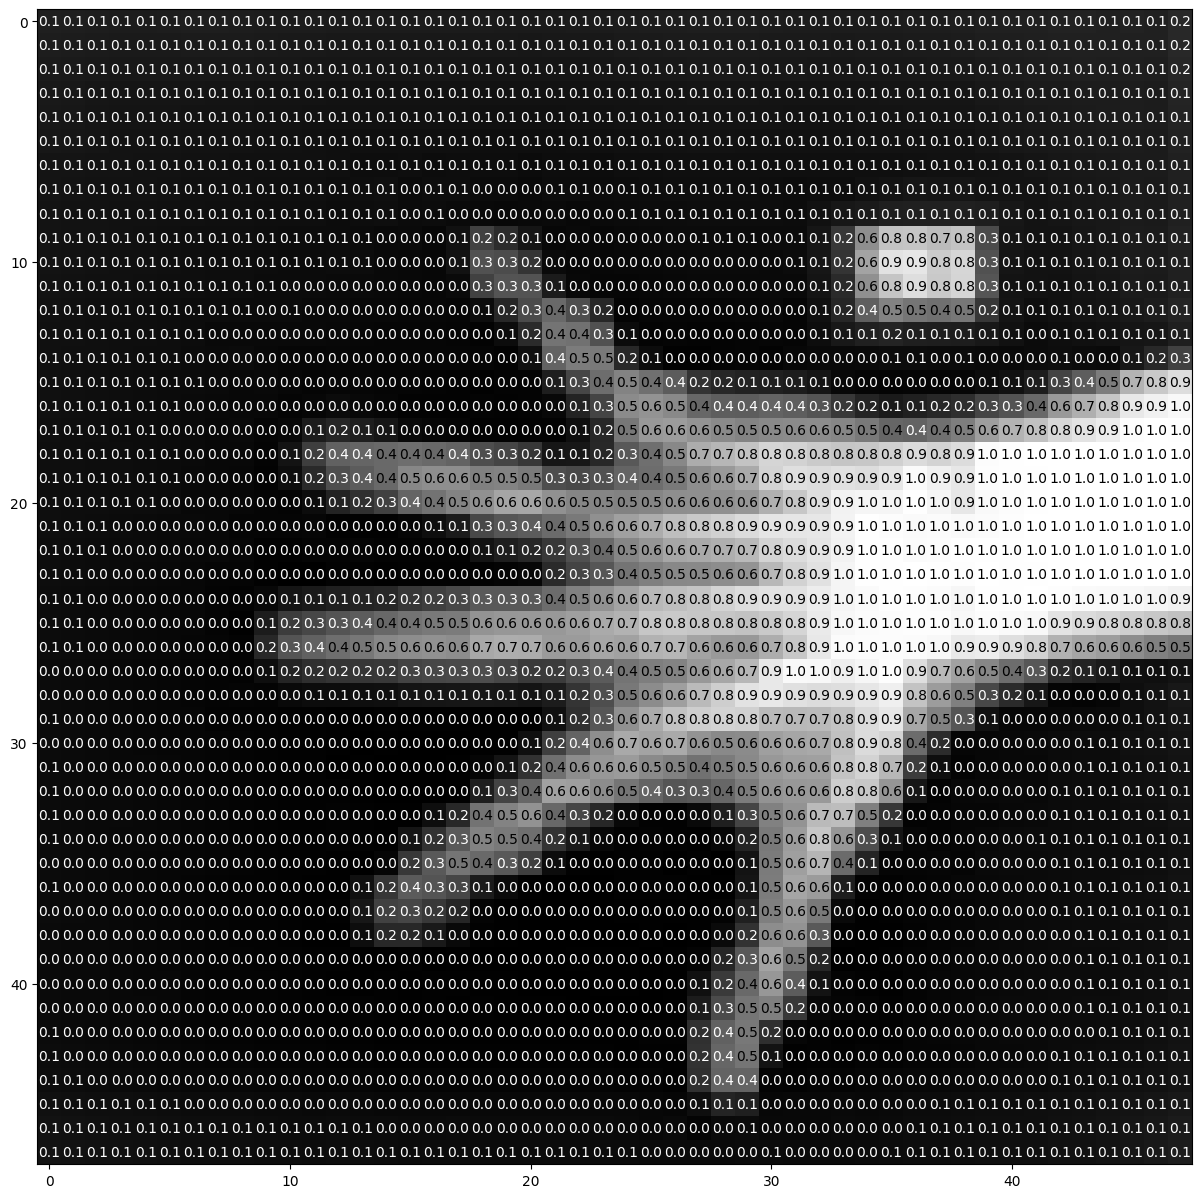

In [5]:
img = np.squeeze(images[0])
print(f"The size of an image from the dataset is {img.shape}")

fig = plt.figure(figsize = (15,15)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(f"{val:.1f}", xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the [VAE network architecture](https://github.com/Project-MONAI/MONAI/blob/dev/monai/networks/nets/autoencoderkl.py#L564)

We will create a VAE network using an pre-defined network from MONAI library. The parameters chosen are sub-optimal, but reduce the complexity of the architecture and make calculation times short enough to run during the lab.

```
Run the two cells below to define the VAE network (seen as the generator in the adversarial scheme) and visualize the main properties of its architecture.
```

In [6]:
# Parameters
spatial_dims = 2
in_channels = 1
out_channels = 1
channels = (16, 32, 64)
latent_channels = 3
num_res_blocks = 2
norm_num_groups = channels[0]
attention_levels = (False, False, False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# use of the with command line to avoid the automatic display of log information during the instanciation of the class model 
with contextlib.redirect_stdout(None):
    model = AutoencoderKL(
        spatial_dims=spatial_dims,
        in_channels=in_channels,
        out_channels=out_channels,
        channels=channels,
        latent_channels=latent_channels,
        num_res_blocks=num_res_blocks,
        norm_num_groups=norm_num_groups,
        attention_levels=attention_levels,
    )
    model.to(device)
    
# Print the summary of the encoder network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "num_params"], depth=3, verbose=0
)
summary(model, (1, 1, image_size, image_size), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
AutoencoderKL                                 [1, 1, 32, 32]            [1, 1, 32, 32]            --
├─Encoder: 1-1                                [1, 1, 32, 32]            [1, 3, 8, 8]              --
│    └─ModuleList: 2-1                        --                        --                        --
│    │    └─Convolution: 3-1                  [1, 1, 32, 32]            [1, 16, 32, 32]           160
│    │    └─AEKLResBlock: 3-2                 [1, 16, 32, 32]           [1, 16, 32, 32]           4,704
│    │    └─AEKLResBlock: 3-3                 [1, 16, 32, 32]           [1, 16, 32, 32]           4,704
│    │    └─AEKLDownsample: 3-4               [1, 16, 32, 32]           [1, 16, 16, 16]           2,320
│    │    └─AEKLResBlock: 3-5                 [1, 16, 16, 16]           [1, 32, 16, 16]           14,528
│    │    └─AEKLResBlock: 3-6                 [1, 32, 16, 16]           

- <span style="color:red">Describe the main characteristics of this network.</span>
- <span style="color:red">How many parameters do the network have in total?</span>
- <span style="color:red">What is the size of the latent space?</span>

### Adversarial scheme

An `adversarial scheme` is employed to encourage the VAE to reconstruct realistic images. To achieve this, a second network, called the `discriminator`, is trained alongside the VAE, which acts as the generator. The generator aims to produce realistic synthetic images, while the discriminator's goal is to determine whether its input image is synthetic (fake) or real. The corresponding diagram is given below:

<img src="img/adversarial-scheme.png" alt="Illustration of an adversarial scheme" width="600">


```
Run the two cells below to define the discriminator network and visualize the main properties of its architecture.
```

In [8]:
# Parameters
spatial_dims = 2
in_channels = 1
out_channels = 1
num_layers_d = 3
channels = 16

In [ ]:
# use of the with command line to avoid the automatic display of log information during the instanciation of the class model 
with contextlib.redirect_stdout(None):    
    discriminator = PatchDiscriminator(
        spatial_dims=spatial_dims,
        num_layers_d=num_layers_d,
        channels=channels,
        in_channels=in_channels,
        out_channels=out_channels,
        activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
        norm="BATCH",
        bias=False,
        padding=1,
    )
    discriminator.to(device)
    
# Print the summary of the network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "num_params"], depth=3, verbose=0
)
summary(discriminator, (1, 1, image_size, image_size), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
PatchDiscriminator                       [1, 1, 32, 32]            [1, 16, 16, 16]           --
├─Convolution: 1-1                       [1, 1, 32, 32]            [1, 16, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 1, 32, 32]            [1, 16, 16, 16]           272
│    └─ADN: 2-2                          [1, 16, 16, 16]           [1, 16, 16, 16]           --
│    │    └─Dropout: 3-1                 [1, 16, 16, 16]           [1, 16, 16, 16]           --
│    │    └─LeakyReLU: 3-2               [1, 16, 16, 16]           [1, 16, 16, 16]           --
├─Convolution: 1-2                       [1, 16, 16, 16]           [1, 32, 8, 8]             --
│    └─Conv2d: 2-3                       [1, 16, 16, 16]           [1, 32, 8, 8]             8,192
│    └─ADN: 2-4                          [1, 32, 8, 8]             [1, 32, 8, 8]             --
│    │    └─BatchNorm2d: 3-3   

- <span style="color:red">Describe the main characteristics of this network.</span>
- <span style="color:red">How many parameters do the network have in total?</span>
- <span style="color:red">What is the output of this network?</span>
- <span style="color:red">What does this mean in relation to the diagram above?</span>

### Perceptual loss term

In an auto-encoder, the `perceptual loss` is a type of loss function that compares high-level features extracted from a pretrained deep neural network (like AlexNet or VGG) rather than directly comparing pixel values. It is used to ensure that the reconstructed image not only matches the original in pixel intensity but also preserves semantic and perceptual similarity (capture by the feature maps). The corresponding implementation is given below.

<img src="img/perceptual-loss.png" alt="Illustration of the perceptual loss" width="600">



###  Specify [Loss Functions](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

The total loss which is optmized corresponds to the sum of 4 terms:

<img src="img/final-loss.png" alt="Final loss" width="500">

```
Run the cell below to define the different terms of the total loss and the corresponding optimizers.
```

In [10]:
## Specify loss and optimization functions
learning_rate_g = 1e-4
learning_rate_d = 5e-4
    
p_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
p_loss.to(device)
adv_loss = PatchAdversarialLoss(criterion="least_squares")
p_loss.to(device)
l1_loss = nn.L1Loss()
l1_loss.to(device)

def vae_gaussian_kl_loss(mu, sigma):
    kl_loss = 0.5 * torch.sum(mu.pow(2) + sigma.pow(2) - torch.log(sigma.pow(2)) - 1, dim=[1, 2, 3])
    kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
    return kl_loss

def reconstruction_loss(x_reconstructed, x):
    return l1_loss(x_reconstructed.float(), x.float())

def perceptual_loss(x_reconstructed, x):
    return p_loss(x_reconstructed.float(), x.float())

def loss_function(recon_x, x, mu, sigma, kl_weight, p_weight, a_weight, logits, target_is_real, for_discriminator):    
    recon_loss = reconstruction_loss(recon_x, x)
    kld_loss = vae_gaussian_kl_loss(mu, sigma)
    p_loss = perceptual_loss(recon_x, x)
    a_loss = adv_loss(logits, target_is_real=target_is_real, for_discriminator=for_discriminator)
    return recon_loss + kl_weight * kld_loss + p_weight * p_loss + a_weight * a_loss, recon_loss.item(), kl_weight * kld_loss.item(), p_weight * p_loss.item(), a_weight * a_loss.item()


# Specify optimizers
optimizer_generator = torch.optim.Adam(model.parameters(), lr=learning_rate_g)
optimizer_discriminator = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate_d)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlist

---
## Training of the adversarial networks

In an adversarial training approach, two networks are trained simultaneously: a generator and a discriminator. The generator (i.e. VAE)'s objective is to produce realistic outputs, in our case synthetic images, that resemble the target data (image) distribution. The discriminator, on the other hand, aims to distinguish between real data samples and those generated by the generator.

During training, the generator tries to "fool" the discriminator by improving the quality of its outputs, while the discriminator learns to become better at identifying fake samples. This creates a competitive dynamic, where the generator and discriminator improve iteratively. The overall goal is to reach a point where the discriminator can no longer reliably distinguish between real and generated samples, indicating that the generator has learned to produce realistic data.

```
Run the cell below to train the adversarial networks. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 
```

In [11]:
# Number of epochs to train the model
n_epochs = 120
kl_weight = 1e-6               # KL divergence weight loss  / default monai value: 1e-6
perceptual_weight = 1e-3       # Perceptual weight for loss / default monai value: 1e-3
adversarial_weight = 1e-2      # Adversarial weight for generator loss / default monai value 1e-2

# Move the model to the device
model.to(device)
discriminator.to(device)

# Lists to store loss and accuracy for each epoch
train_generator_loss_list = []
train_discriminator_loss_list = []
valid_metric_list = []
reconstruction_metric_list = []
kld_metric_list = []
perceptual_metric_list = []
adversarial_metric_list = []

save_best_model_from_metric = True
best_valid_metric = float('inf')  # to track the best validation mesasure
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    # monitor training loss
    model.train()  # ensure the model is in training mode
    discriminator.train()
    train_generator_loss = 0
    train_discriminator_loss = 0
    reconstruction_metric = 0
    kld_metric = 0
    perceptual_metric = 0
    adversarial_metric = 0
    
    ################################
    # train the adversarial models #
    ################################
    for batch_data in train_loader:
        
        ###################        
        # Generator part
        ###################        
        
        # Load data and target samples stored the current batch_data
        inputs = batch_data["image"].to(device)
        # clear the gradients of all optimized variables
        optimizer_generator.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, z_mu, z_sigma = model(inputs)
        # predict fake logits  
        logits_fake = discriminator(reconstruction.contiguous().float())[-1]
        # calculate the generator loss
        loss_generator, reconstruction_val, kld_val, perceptual_val, adversarial_val = loss_function(
            reconstruction, 
            inputs, 
            z_mu, 
            z_sigma, 
            kl_weight, 
            perceptual_weight,
            adversarial_weight,
            logits_fake,
            target_is_real=True,
            for_discriminator=False)
                
        # backpropagate
        loss_generator.backward()
        # perform a single optimization step (parameter update)
        optimizer_generator.step()
        # update running training generator loss
        train_generator_loss += loss_generator.item() * inputs.size(0)
        reconstruction_metric += reconstruction_val * inputs.size(0)
        kld_metric += kld_val * inputs.size(0)
        perceptual_metric += perceptual_val * inputs.size(0)
        adversarial_metric += adversarial_val * inputs.size(0)
        
        ###################        
        # Discriminator part
        ###################        
        
        if adversarial_weight > 0:
        
            # clear the gradients of all optimized variables        
            optimizer_discriminator.zero_grad(set_to_none=True)
            # predict fake logits
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            # compute real logits
            logits_real = discriminator(inputs.contiguous().detach())[-1]
            # calculate the discriminator loss
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5
            loss_discriminator = adversarial_weight * discriminator_loss

            # backpropagate
            loss_discriminator.backward()
            # perform a single optimization step (parameter update)        
            optimizer_discriminator.step()
            # update running training discriminator loss
            train_discriminator_loss += loss_discriminator.item() * inputs.size(0)
        
        
    # Calculate average training loss and accuracy over the epoch
    train_generator_loss_list.append(train_generator_loss / len(train_loader.dataset))
    reconstruction_metric_list.append(reconstruction_metric / len(train_loader.dataset))
    kld_metric_list.append(kld_metric / len(train_loader.dataset))
    perceptual_metric_list.append(perceptual_metric / len(train_loader.dataset))
    adversarial_metric_list.append(adversarial_metric / len(train_loader.dataset))
    
    if adversarial_weight > 0:
        train_discriminator_loss_list.append(train_discriminator_loss / len(train_loader.dataset))

    ###################
    # Validation step #
    ###################    
    model.eval()  # set model to evaluation mode
    valid_metric = 0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            inputs = batch_data["image"].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            reconstruction, z_mu, z_sigma = model(inputs)
            # calculate the loss
            recon_val = reconstruction_loss(reconstruction.float(), inputs.float())
            valid_metric += recon_val.item() * inputs.size(0)

    # Compute average validation loss and accuracy
    valid_metric_list.append(valid_metric / len(valid_loader.dataset))
        
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_generator_loss_list[-1]:.6f} \tValidation metric: {valid_metric_list[-1]:.6f}')

    if save_best_model_from_metric:
        # Save the model if it has the best validation loss
        if valid_metric_list[-1] < best_valid_metric:
            best_valid_metric = valid_metric_list[-1]
            best_model = model.state_dict()
            best_epoch = epoch + 1  # Save the epoch number
    else:
        # Save the last model as best model
        best_valid_metric = valid_metric_list[-1]
        best_epoch = epoch + 1
        best_model = model.state_dict()

# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_test_lossmodel.pth')  # Save the best model

print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_metric:.6f}")



Epoch: 1 	Training Loss: 0.221451 	Validation metric: 0.151438
Epoch: 2 	Training Loss: 0.152619 	Validation metric: 0.137275
Epoch: 3 	Training Loss: 0.136939 	Validation metric: 0.117224
Epoch: 4 	Training Loss: 0.114371 	Validation metric: 0.095284
Epoch: 5 	Training Loss: 0.095798 	Validation metric: 0.082479
Epoch: 6 	Training Loss: 0.088610 	Validation metric: 0.076340
Epoch: 7 	Training Loss: 0.083702 	Validation metric: 0.074063
Epoch: 8 	Training Loss: 0.079886 	Validation metric: 0.071710
Epoch: 9 	Training Loss: 0.079019 	Validation metric: 0.071076
Epoch: 10 	Training Loss: 0.073880 	Validation metric: 0.064172
Epoch: 11 	Training Loss: 0.069323 	Validation metric: 0.060880
Epoch: 12 	Training Loss: 0.067180 	Validation metric: 0.055907
Epoch: 13 	Training Loss: 0.063368 	Validation metric: 0.051594
Epoch: 14 	Training Loss: 0.063607 	Validation metric: 0.057163
Epoch: 15 	Training Loss: 0.062308 	Validation metric: 0.052284
Epoch: 16 	Training Loss: 0.059942 	Validation me

---
## Evaluate the performance of our trained model on a test dataset

```
Run the following cell to display the evolution of the training loss and the validation metric curves to investigate the success of the learning process
```


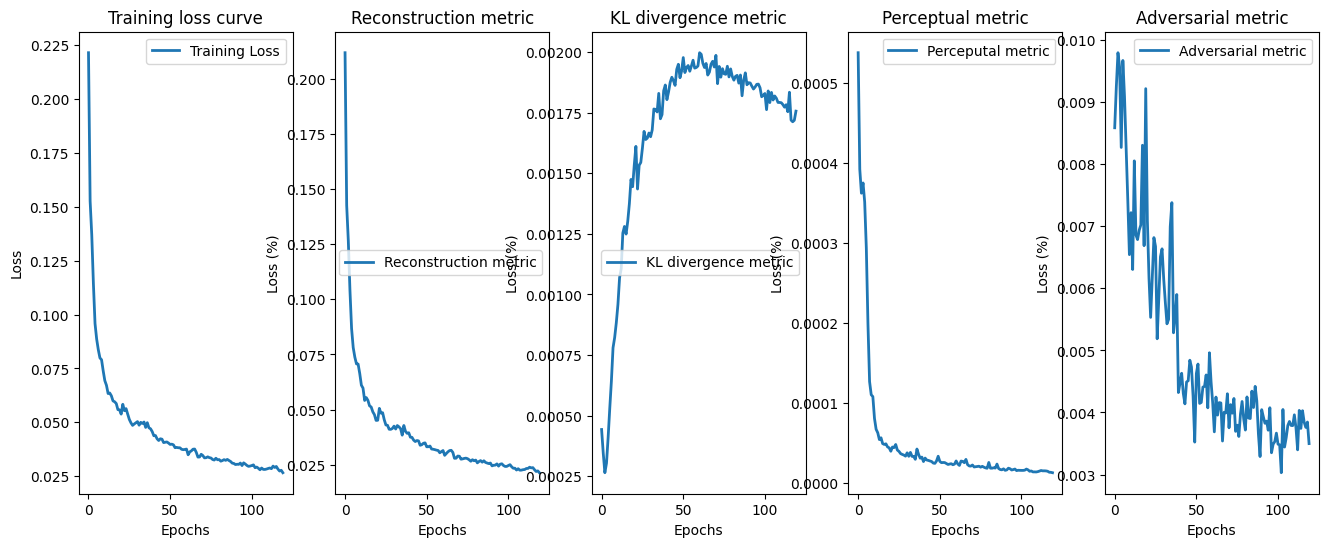

In [12]:
# Plot loss curves
plt.figure(figsize=(16, 6))

# Plotting global loss
plt.subplot(1, 5, 1)
plt.plot(train_generator_loss_list, color="C0", linewidth=2.0, label='Training Loss')
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Reconstruction loss
plt.subplot(1, 5, 2)
plt.plot(reconstruction_metric_list, color="C0", linewidth=2.0, label='Reconstruction metric')
plt.title('Reconstruction metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

# Plotting KL loss
plt.subplot(1, 5, 3)
plt.plot(kld_metric_list, color="C0", linewidth=2.0, label='KL divergence metric')
plt.title('KL divergence metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

# Plotting Perceptual loss
plt.subplot(1, 5, 4)
plt.plot(perceptual_metric_list, color="C0", linewidth=2.0, label='Perceputal metric')
plt.title('Perceptual metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

# Plotting Perceptual loss
plt.subplot(1, 5, 5)
plt.plot(adversarial_metric_list, color="C0", linewidth=2.0, label='Adversarial metric')
plt.title('Adversarial metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

- <span style="color:red">Analyse the evolution of the different curves and compare the weight of each in relation to the total loss.</span>
- <span style="color:red">What conclusions can be drawn?</span>

### Compare the generator and discriminator losses

```
Run the cell below to investigate the evolution of the loss function of the generator and the discriminator to analyze the influence of each term
```

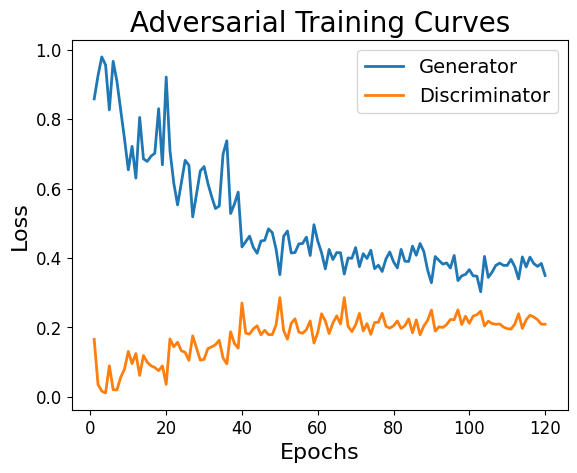

In [13]:
if adversarial_weight > 0:

    # Express the adversarial terms without the weight coefficient
    generator_list = [x / adversarial_weight for x in adversarial_metric_list]
    discriminator_list = [x / adversarial_weight for x in train_discriminator_loss_list]

    plt.title("Adversarial Training Curves", fontsize=20)
    plt.plot(np.linspace(1, n_epochs, n_epochs), generator_list, color="C0", linewidth=2.0, label="Generator")
    plt.plot(np.linspace(1, n_epochs, n_epochs), discriminator_list, color="C1", linewidth=2.0, label="Discriminator")
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    
    # Save the figure as a PNG file
    plt.savefig("img/adversarial_training_curves.png", dpi=300, bbox_inches="tight")
    
    plt.show()


This figure has been automotically saved in the folder img with the name "adversarial-training-curves.png". You will use chat-gpt to help you to analysis these curves.

```
Upload the image on chat-pgt and type the command prompt bellow
```

"I trained an adversarial approach to train a VAE from the AutoencoderKL class from Monai. I obtained the folloing curves for the generator and discriminator losses, can you help me to analysis them ? What conclusions can be drawn from this figure ?"

- <span style="color:red">Based on chat-gpt feedback, what is your own analysis of these curves?</span>

### Compute the overall performance on the test dataset

We then test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well.

`model.eval()` will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

```
Run the following cell to compute the scores of the trained network on the test dataset
```

In [22]:
# initialize lists to monitor test loss and accuracy
test_metric = 0.0

model.eval() # prep model for *evaluation*

with torch.no_grad():  # disable gradient calculation during validation
    for batch_data in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        inputs = batch_data["image"].to(device)
        reconstruction, z_mu, z_sigma = model(inputs)
        # calculate the loss
        recon_val = reconstruction_loss(reconstruction.float(), inputs.float())
        test_metric += recon_val.item() * inputs.size(0)    
    
# calculate and print avg test loss
test_metric = test_metric / len(test_loader.dataset)
print('Test reconstruction metric: {:.6f}\n'.format(test_metric))

# Prepare next cell
dataiter = iter(test_loader)

Test reconstruction metric: 0.021644



- <span style="color:red">Compare the scores obtained on the validation data and the test data. Conclusions?</span>

### Visualize Sample Test Results

```
Run the cell below to display reconstructed images taken from the test dataset in the following order: reference image (left) and reconstructed one (right), i.e. the output of the VAE network.
```

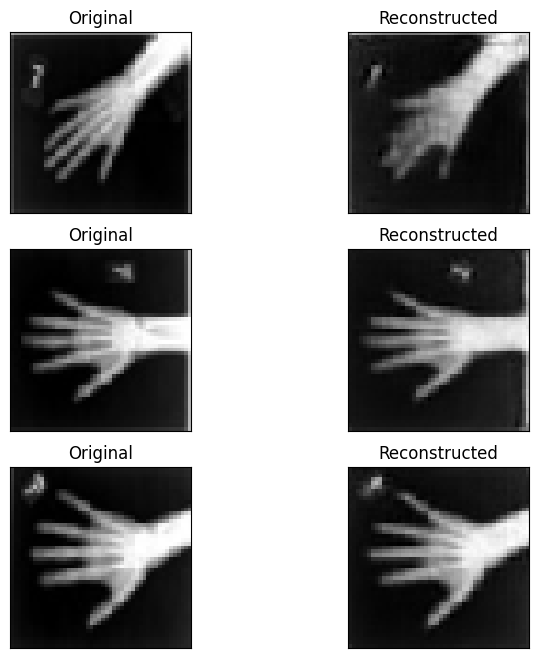

In [ ]:
# obtain one batch of test images
batch_data = next(dataiter)
batch_data = next(dataiter)

# get sample outputs
inputs = batch_data["image"].to(device)
recons, _, _ = model(inputs)
# reconstruction images for display
recons = recons.detach().cpu().numpy()
inputs = inputs.detach().cpu().numpy()

# Plot the image, label and prediction
fig = plt.figure(figsize=(8, 8))
for idx in range(3):
    ax = fig.add_subplot(3, 2, 2*idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(inputs[idx]), cmap='gray')
    ax.set_title('Original')
    ax = fig.add_subplot(3, 2, 2*idx+2, xticks=[], yticks=[])
    ax.imshow(np.squeeze(recons[idx]), cmap='gray')
    ax.set_title('Reconstructed')

- <span style="color:red">Can you comment on the difference in reconstruction quality compared to the results obtained with the previous Jupyter notebooks ?</span>

### Visualize latent space thanks to t-SNE

It can be useful to visualize the latent space to study its structure. Since the dimensions of the latent space are not in 2D, we use a more sophisticated method, called t-SNE, to perform this visualization.

```
Run the 2 cells below to compute and display the latent space
```

In [16]:
downsampling_ratio = 1
counter = 0  # counter initialisation

model.eval() # prep model for *evaluation*
z_mu_accumulated = []

with torch.no_grad():  # Deactivate the gradient computations
    for batch_data in test_loader:
        counter += 1
        if counter % downsampling_ratio == 0:
            # forward pass: compute predicted outputs by passing inputs to the model
            inputs = batch_data["image"].to(device)
            z_mu, _ = model.encode(inputs)
            z_mu_accumulated.append(z_mu.cpu().numpy())
      
z_mu_accumulated = np.concatenate(z_mu_accumulated, axis=0)

z_mu_flattened = z_mu_accumulated.reshape(z_mu_accumulated.shape[0], -1)
print(f"Size of the latent matrix passed to the t-SNE method (Nb Sample, vector dimensionality) = {z_mu_flattened.shape}")

# Apply t-SNE to reduce the dimensionality to 2 and allows a visualization of the latent space
tsne = TSNE(n_components=2, random_state=42)
z_mu_tsne = tsne.fit_transform(z_mu_flattened)


Size of the latent matrix passed to the t-SNE method (Nb Sample, vector dimensionality) = (223, 432)


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


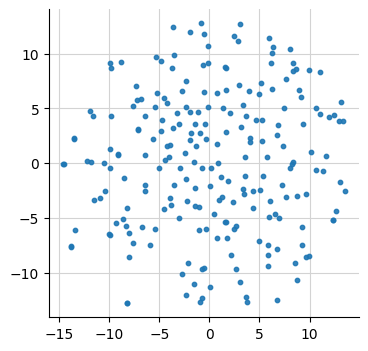

In [17]:
show_grid = True
fig, ax = plt.subplots(figsize=(8, 8) if not show_grid else (4, 4))

# create a scatter plot of the embeddings, colored by the labels
scatter = ax.scatter(
    x=z_mu_tsne[:, 0], 
    y=z_mu_tsne[:, 1], 
    cmap="tab10", 
    s=10, 
    alpha=0.9,
    zorder=2,
    )

# remove the top and right spines from the plot
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# if show is True, display the plot
if show_grid:
    # add a grid to the plot
    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
    # plt.show()
# otherwise, save the plot to a file and close the figure
else:
    plt.savefig("latent_space.png", bbox_inches="tight")
    plt.close()

- <span style="color:red">What does the size of the latent matrix passed to the t-SNE method correspond to ?</span>
- <span style="color:red">What is the size of the matrix generated by the t-SNE method ?</span>
- <span style="color:red">Analyze and interpret the latent space obtained ?</span>

### Plot random images

Now it is time to test the capacity of generating new synthetic digits. This is done in two steps:
1) samples directly from the latent space;
2) use the decoder to project the sample into the image space to generate the synthetic image.

```
Run the cell below to compute and display the latent space from a grid of points sampled directed from the latent space
```

torch.Size([31, 1, 48, 48])
The input image is of size torch.Size([1, 1, 48, 48])
The latent sample is of size torch.Size([1, 3, 12, 12])
The reconstrudted image is of size torch.Size([1, 1, 48, 48])


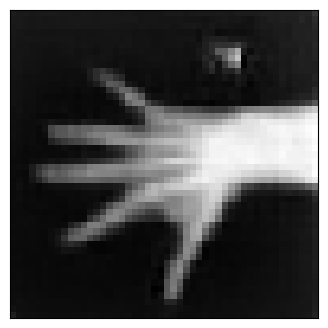

In [18]:
random_generation = False

if random_generation:
    z_mu = torch.randn(1, 4, 8, 8).to(device)
else:
    inputs = batch_data["image"].to(device)
    print(inputs.shape)
    input = inputs[2]
    input = input.unsqueeze(0)
    print(f"The input image is of size {input.shape}")
    z_mu, _ = model.encode(input)

print(f"The latent sample is of size {z_mu.shape}")

# Decode latent sample
reconstruction = model.decode(z_mu)
print(f"The reconstrudted image is of size {reconstruction.shape}")

img = reconstruction.squeeze().detach().cpu().numpy()
img = np.squeeze(img)

fig = plt.figure(figsize = (4,4)) 
ax = fig.add_subplot(111, xticks=[], yticks=[])
ax.imshow(img, cmap='gray')


### Let's create a cool animation ;)

```
Run the three cells below to generate an animation that allows you to study the properties of latent space. 
```

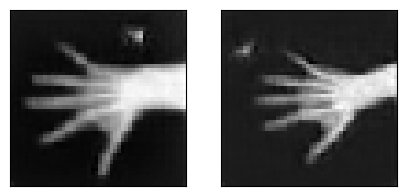

In [19]:
# Randomly select two points in the latent space
inputs = batch_data["image"].to(device)
input = inputs[2]
input = input.unsqueeze(0)
latent_1, _ = model.encode(input)
input = inputs[4]
input = input.unsqueeze(0)
latent_2, _ = model.encode(input)

synthetic_1 = model.decode(latent_1)
synthetic_2 = model.decode(latent_2)

img_1 = synthetic_1.squeeze().detach().cpu().numpy()
img_1 = np.squeeze(img_1)
img_2 = synthetic_2.squeeze().detach().cpu().numpy()
img_2 = np.squeeze(img_2)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(1,2,1, xticks=[], yticks=[])
ax.imshow(img_1, cmap='gray')
ax = fig.add_subplot(1,2,2, xticks=[], yticks=[])
ax.imshow(img_2, cmap='gray')


In [20]:
def interpolate_images(model, latent_1, latent_2, steps=10):
    # Interpolate between point1 and point2 in the latent space
    
    latent_1.to(device)
    latent_2.to(device)
    t_values = torch.linspace(0, 1, steps).to(device)    
    latent_tmp = [torch.lerp(latent_1, latent_2, t).to(device) for t in t_values]
    latent_interp = torch.stack([latent.squeeze(0) for latent in latent_tmp], dim=0)
    synthetic_interp = model.decode(latent_interp)
    
    # Return images as a list after detaching and converting to numpy
    return [img.squeeze().detach().cpu().numpy() for img in synthetic_interp]

def save_animation_as_gif(images, filename="animation.gif", interval=200):
    fig, ax = plt.subplots(figsize = (2,2))
    img_display = ax.imshow(images[0], cmap="gray", vmin=0, vmax=1)
    ax.axis("off")

    def update(frame):
        img_display.set_data(images[frame])
        return [img_display]

    ani = FuncAnimation(fig, update, frames=len(images), interval=interval, blit=True)
    ani.save(filename, writer="pillow", fps=1000//interval)
    plt.close(fig) 


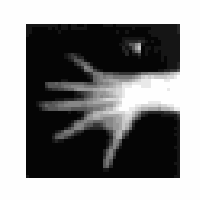

In [21]:
# Interpolate between the two points and decode to generate images
images = interpolate_images(model, latent_1, latent_2, steps=64)

# Animate the interpolated images
filename = "mnist_interpolation.gif"
save_animation_as_gif(images, filename=filename, interval=100)

# Affiche le GIF dans Jupyter
display(Image(filename=filename))   

---
## Additional questions

Now that you have mastered this code, try experimenting with the properties of the two networks to study their influence on the quality of the results

- <span style="color:red">Evaluate the influence of the kl_weight, perceptual_weight and adversarial_weight values, setting some of them to 0.</span>
- <span style="color:red">Evaluate the influence of the two network architectures. Try for instance to modify the number of layers (through channels), the type of layer (through num_res_blocks) or the latent dimension (through latent_channels). Be careful with the number of associated parameters so that the model to train is not too large.</span>
- <span style="color:red">Try to optimize the different networks to get the best results.</span>
